# Active (sequential) learning for experimental band gap prediction

## Overview
### Context
The band gap of a material dictates many of its electrical properties and defines whether or not it is an insulator, a semiconductor, or a conductor. A model that can predict the experimental band gap of a given material, as well as guide/screen new materials is useful in a variety of electronic applications.
### Problem formulation
Develop a machine learning (ML) model that can predict the experimental band gap of a material given only its composition. Utilize active learning to guide the exploration of design space to optimize the band gap for a certain application. Here, we will seek to maximize the band gap (e.g., identify insulators), but one could use the same approach to minimize or optimize to a certain energy range.
## Approach
### 1. Data set importing and featurization will be done via `matminer`.
- Will use the `matbench_expt_gap`
    - For the sake of time, I filtered out all materials with a band gap of zero. Ideally, I would develop a classification model to identify metals as an initial pre-screening step before performing regression. Then for prediction on a new material, metals could automatically be assigned a band gap of zero and all others could use the trained regression model.
- For now, will only use compositional features
     
### 2. As the output (i.e., target variable) is continuous, we will use regression.
- I chose random forest because it is relatively robust, especially for smaller data sets (relative to neural networks)
- Hyperparameter tuning and feature selection are done with `sklearn`
- Final model training and prediction is done with `lolopy` because its random forest regressor has an option to return the standard deviation of the predictions from all trees (needed for two of the acquisition functions)
     
### 3. For active learning, we will test several acquisition functions for each step of training data additions.
- MEI (Maximum Expected Improvement), MLI (Maximum Likelihood of Improvement) and MU (Maximum Uncertainty)
    - Uncertainty estimates for random forest can be found [here](https://jmlr.org/papers/volume15/wager14a/wager14a.pdf).

# Import modules 

In [112]:
# General python 
from itertools import combinations
from scipy import stats
import pandas as pd
import numpy as np

# Plotting
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib.animation as animation
import seaborn as sns

# Data and feature engineering
from matminer.datasets import load_dataset,get_all_dataset_info
from matminer.featurizers.base import MultipleFeaturizer
from matminer.featurizers import composition as cf
from matminer.featurizers import structure as st
from pymatgen.core import Composition

# Exploratory data analysis
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Machine learning training & prediction
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor as skl_RandomForestRegressor
from lolopy.learners import RandomForestRegressor

# Model persistence
from joblib import dump, load

# To ignore warnings
import warnings
warnings.filterwarnings('ignore')

# General functions

In [113]:
# Plotting

myrcparams = {
    'axes.labelsize': 24,
    'axes.titlesize': 24,
    'axes.xmargin': 0,
    'axes.ymargin': 0,
    'legend.fontsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}

def absHighPass(df, absThresh):
    """
    Filters out pairs of variables with a correlation below
    a threshold.

    Parameters
    ----------
    df : pandas dataframe 
            The feature correlation matrix
    absThresh : float
            Threshold on the correlation coefficient

    Returns
    -------
    pandas dataframe
        The feature correlation matrix containing only pairs
        with correlation coeffs. abote absThresh
    """
    passed = set()
    for (r,c) in combinations(df.columns, 2):
        if (abs(df.loc[r,c]) >= absThresh):
            passed.add(r)
            passed.add(c)
    passed = sorted(passed)
    return df.loc[passed,passed]

def corrplot(df, figsize=(10,7)):
    """
    Plots a heatmap of the correlation matrix.

    Parameters
    ----------
    df : pandas dataframe 
            The feature correlation matrix
    figsize : tuple
            Size of the figure

    Returns
    -------
    None
    """
    fig,ax = plt.subplots(figsize = figsize)
    sns.set(font_scale = 1.5)
    sns.heatmap(df, annot = False, vmin = -1, vmax = 1, cmap = 'coolwarm')

def boxplot(df, features, nrows = 2, figsize = (15,10)):
    """
    Creates a boxplot for specified features.

    Parameters
    ----------
    df : pandas dataframe 
            Input data
    features : list-like
            List of features to plot
    nrows : int
            Number of rows in subplot
    figsize : tuple
            Size of figure

    Returns
    -------
    None
    """
    ncols = len(features) // nrows
    ind = np.unravel_index(range(len(features)), (nrows, ncols))
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, 
                                           figsize = figsize
                                           )
    boxprops = dict(linestyle='-', linewidth=1.5, facecolor='lavender', edgecolor='indigo')
    flierprops = dict(marker='o', markerfacecolor='lavender', markeredgecolor='indigo', markersize=8)
    whiskerprops = dict(linewidth=1.5, color='indigo')
    capprops = dict(linewidth=1.5, color='indigo')
    medianprops = dict(linewidth=1.5, linestyle='-', color='indigo')
    meanprops = dict(markerfacecolor='indigo', markeredgecolor='indigo', marker='^', markersize=8)
    if len(features) == 1:
        sns.boxplot(df[features[0]], ax = axes, showmeans = True, boxprops=boxprops, whiskerprops=whiskerprops,
                capprops=capprops, flierprops=flierprops, medianprops=medianprops, meanprops=meanprops) #boxplot 
                #will be created and a symbol will indicate the mean value of the column   

    else:
        for i,feature in enumerate(features):
            row = ind[0][i]
            col = ind[1][i]
            sns.boxplot(df[feature], ax = axes[row,col], showmeans = True, boxprops=boxprops, whiskerprops=whiskerprops,
                capprops=capprops, flierprops=flierprops, medianprops=medianprops, meanprops=meanprops) 
                #boxplot will be created and a symbol will indicate the mean value of the column   
    sns.set_color_codes()
    
def distplot(df, features, nrows = 2, figsize = (15,10), bins = None):
    """
    Creates a plot of the distributions for the specified features.

    Parameters
    ----------
    df : pandas dataframe 
            Input data
    features : list-like
            List of features to plot
    nrows : int
            Number of rows in subplot
    figsize : tuple
            Size of figure
    bins : None, 'auto', or int
            Number of bins 

    Returns
    -------
    None
    """
    ncols = len(features) // nrows
    ind = np.unravel_index(range(len(features)), (nrows, ncols))
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, 
                                           figsize = figsize
                                           )
    if len(features) == 1:
        sns.set_color_codes()
        if bins:
            sns.distplot(df[features[0]], kde = F, ax = axes, bins = bins, color="dodgerblue") 
        else:
            sns.distplot(df[features[0]], kde = False, ax = axes, color="dodgerblue") # For histogram
    
        axes.axvline(np.mean(df[features[0]]), color = 'blue', linestyle = '--', linewidth=1.7) # Add mean 
    
        axes.axvline(np.median(df[features[0]]), color = 'black', linestyle = '-', linewidth=1.6) # Add median
    else:
        for i,feature in enumerate(features):
            row = ind[0][i]
            col = ind[1][i]
            sns.set_color_codes()
            if bins:
                sns.distplot(df[feature], kde = F, ax = axes[row,col], bins = bins, color="dodgerblue")
            else: 
                sns.distplot(df[feature], kde = False, ax = axes[row,col], color="dodgerblue") # For histogram
    
            axes[row,col].axvline(np.mean(df[feature]), color = 'blue', linestyle = '--', linewidth=1.7) # Add mean 
    
            axes[row,col].axvline(np.median(df[feature]), color = 'black', linestyle = '-', linewidth=1.6) # Add median 

def predvtrue(y_true,y_pred):
    """
    Parity plot of predicted gaps vs. true gaps.

    Parameters
    ----------
    y_true : numpy array
            True gaps
    y_pred : numpy array
            Predicted gaps

    Returns
    -------
    None
    """ 
    
    plt.plot(y_true, y_true, color='black',linewidth=1.5)

    # Calculate the point density  
    xy = np.vstack([y_true,y_pred])
    z = stats.gaussian_kde(xy)(xy)

    # Sort the points by density, so that the most dense points are plotted last
    idx = z.argsort()
    y_true, y_pred, z = y_true[idx], y_pred[idx], z[idx]

    # scatter plot
    plt.scatter(y_true,y_pred,c=z,s=80,cmap="viridis")
    plt.xlabel(r'y$_\mathrm{test}$')
    plt.ylabel(r'y$_\mathrm{pred}$')

In [114]:
# Hyperparameter tuning and feature selection
def tune(X_df, y_ser, in_train = 'all', outf = 'grid_search_trained_model'):
    """
    Performs an initial round of hyperparameter tuning with all features, then feature selection,
    and finally a final round of hyperparameter tuning with top features from feature selection.

    Parameters
    ----------
    X_df : pandas dataframe 
            Input data
    y_ser : pandas series
            Target data
    in_train: 'all' or list-like
            Rows to include in training set

    Returns
    -------
    best_params : dict
            Tuned hyperparameters
    best_estimator : sklearn estimator
            Tuned model
    top_feat : list-like
            Top features from feature selection
    outf : str
            Prefix for joblib file containing tuned model
    """
    X = np.array(X_df)
    y = np.array(y_ser)
    if in_train == 'all':
        in_train = list(range(len(y)))
        X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)
    else:
        X_train = X[in_train]
        y_train = y[in_train]
        X_test = X[~in_train]
        y_test = y[~in_train]
    
    # Hyperparameters to tune - here I only tune the number of trees and the maximum
    # depth because these are the two primary common hyperparameters between
    # sklearn's and lolopy's random forest regressors
    dense_grid = {'n_estimators': [15, 20, 50, 100, 200],
                  'max_depth': [5,10,20,50,100,1073741824]
    }
    # Hyperparameter tuning with sklearn
    model = skl_RandomForestRegressor()
    grid = GridSearchCV(estimator = model, param_grid = dense_grid, cv = 3, verbose=2,  n_jobs = -1)
    grid.fit(X_train, y_train)
    best_params = grid.best_params_
    best_estimator = grid.best_estimator_

    # Feature selection
    result = permutation_importance(
        best_estimator, X_test, y_test, scoring = "r2", n_repeats=10, random_state=42
    )
    forest_importances = pd.Series(result.importances_mean, index=X_df.columns)
    std = result.importances_std
    sorted_ind = forest_importances.argsort()[::-1]
    sorted_importances = forest_importances.sort_values(ascending=False)
    if in_train == 'all':
        top_feat = sorted_importances[ sorted_importances > 0.0 ].index
    else:
        top_feat = sorted_importances[ :10 ].index
    X = np.array(df[top_feat])

    # Final round of hyperparameter tuning
    tmp = grid.fit(X_train, y_train)
    best_params = grid.best_params_
    best_estimator = grid.best_estimator_
    # Save tuned model
    dump(best_estimator, '{}.joblib'.format(outf))
    return best_params, best_estimator, top_feat

In [115]:
# Active learning: function to update training set
def update(X, y_pred, y_std, train_inds, acq = 'mei', n = 5):
    all_inds = set(range(len(X))) # indices for entire dataset
    search_inds = list(all_inds.difference(train_inds)) # test set indices
    acq = acq.lower()
    if acq == 'mei':
        return train_inds + [search_inds[s] for s in y_pred.argsort()[::-1][:n]]
    elif acq == 'mli':
        return train_inds + [search_inds[s] for s in (np.divide(y_pred-np.max(y[train_inds]),y_std)).argsort()[::-1][:n]]
    elif acq == 'mu':
        return train_inds + [search_inds[s] for s in y_std.argsort()[::-1][:n]]
    else:
        return train_inds + [s for s in np.random.choice(search_inds, n)] 

# Load data and featurize

In [116]:
# Load data
df = load_dataset('matbench_expt_gap')
print(get_all_dataset_info('matbench_expt_gap'))
df.drop(df[df['gap expt'] == 0].index, inplace = True)
df.reset_index(inplace = True)

Dataset: matbench_expt_gap
Description: Matbench v0.1 test dataset for predicting experimental band gap from composition alone. Retrieved from Zhuo et al. supplementary information. Deduplicated according to composition, removing compositions with reported band gaps spanning more than a 0.1eV range; remaining compositions were assigned values based on the closest experimental value to the mean experimental value for that composition among all reports. For benchmarking w/ nested cross validation, the order of the dataset must be identical to the retrieved data; refer to the Automatminer/Matbench publication for more details.
Columns:
	composition: Chemical formula.
	gap expt: Target variable. Experimentally measured gap, in eV.
Num Entries: 4604
Reference: Y. Zhuo, A. Masouri Tehrani, J. Brgoch (2018) Predicting the Band Gaps of Inorganic Solids by Machine Learning J. Phys. Chem. Lett. 2018, 9, 7, 1668-1673 https:doi.org/10.1021/acs.jpclett.8b00124.
Bibtex citations: ["@Article{Dunn2020

## Data pre-processing
Check for null values and duplicated rows. In this data set, neither of these exist, so no data pre-processing is performed.

In [117]:
# Clean data: Check for null values and duplicates
print('Null values?')
print(df.isnull().any())
print('\nDuplicated rows?')
print(df['composition'].duplicated().any())

Null values?
index          False
composition    False
gap expt       False
dtype: bool

Duplicated rows?
False


## Featurization based on composition

In [118]:
# Convert formula to composition for each sample
def get_composition(formula):
    return Composition(formula)
df['composition'] = df['composition'].apply(get_composition)
df

,index,composition,gap expt
0,2,"(Ag, Ge, Pb, S)",1.83
1,3,"(Ag, Ge, Pb, Se)",1.51
2,6,"(Ag, Ge, S)",1.98
3,7,"(Ag, Ge, Se)",0.90
4,8,"(Ag, Hg, I)",2.47
...,...,...,...
2149,4584,"(Zr, Ni, Sb)",0.55
2150,4586,"(Zr, O)",4.99
2151,4592,"(Zr, S)",2.75
2152,4596,"(Zr, Se)",2.00


In [119]:
# Feature engineering: Get compositional features from matminer
compf =  MultipleFeaturizer([cf.Stoichiometry(), cf.ElementProperty.from_preset("magpie"),
                         cf.ValenceOrbital(props=['avg']), cf.IonProperty(fast=True)])

df = compf.featurize_dataframe(df, col_id = 'composition')
df.columns

MultipleFeaturizer:   0%|          | 0/2154 [00:00<?, ?it/s]

Index(['index', 'composition', 'gap expt', '0-norm', '2-norm', '3-norm',
       '5-norm', '7-norm', '10-norm', 'MagpieData minimum Number',
       ...
       'MagpieData mean SpaceGroupNumber',
       'MagpieData avg_dev SpaceGroupNumber',
       'MagpieData mode SpaceGroupNumber', 'avg s valence electrons',
       'avg p valence electrons', 'avg d valence electrons',
       'avg f valence electrons', 'compound possible', 'max ionic char',
       'avg ionic char'],
      dtype='object', length=148)

In [120]:
# Split data into input and output
X_col = compf.feature_labels() # only want to use the compositional features for ML
df[X_col+['gap expt']].to_csv('featurized.csv')
#feat_df = pd.read_csv('featurized.csv') # option to read in from csv instead of computing features every time
X_df = df[X_col]
y = df['gap expt']

# Exploratory Data Analysis

## Feature correlations
Here, I analyze the correlations between each feature pair and drop any that are very highly correlated ( correlation coefficient > 0.8 ).

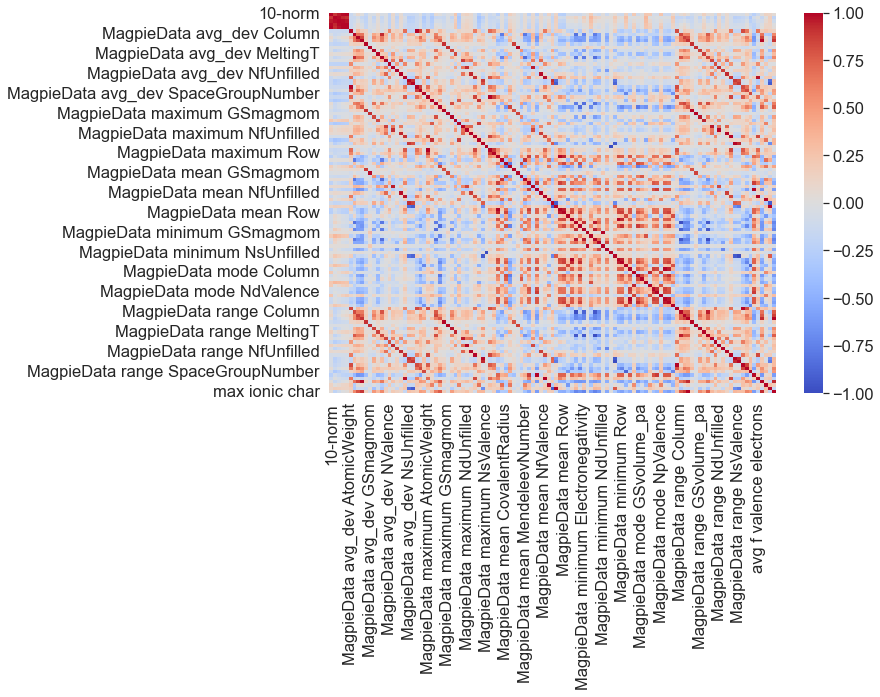

In [121]:
# Plot highly correlated pairs
X_corr = X_df.corr()
corrplot(absHighPass(X_corr,0.8))

In [122]:
# Drop one of each highly correlated pair
c = X_corr.abs()

s = c.unstack()
so = s.sort_values(kind="quicksort")
corr_var = so[ (so >= 0.8) & (so < 1.0) ].drop_duplicates()

neg_corr = {}
pos_corr = {}
for pair in corr_var.index:
    this_corr = X_corr.loc[pair[0], pair[1]]
    if this_corr > 0:
        pos_corr[pair] = this_corr
    else:
        neg_corr[pair] = this_corr
for key, value in pos_corr.items():
    print(key, ' : ', value)
    if key[0] in X_df.columns:
        X_df.drop(columns = key[0], inplace = True)
    else:
        if key[1] in X_df.columns:
            X_df.drop(columns = key[1], inplace = True)
for key, value in neg_corr.items():
    print(key, ' : ', value)
    if key[0] in X_df.columns:
        X_df.drop(columns = key[0], inplace = True)
    else:
        if key[1] in X_df.columns:
            X_df.drop(columns = key[1], inplace = True)

('MagpieData range GSbandgap', 'MagpieData mean GSbandgap')  :  0.8017047247891291
('MagpieData minimum CovalentRadius', 'MagpieData mean CovalentRadius')  :  0.8027860785844545
('MagpieData minimum AtomicWeight', 'MagpieData mean AtomicWeight')  :  0.8030117347243341
('MagpieData mode AtomicWeight', 'MagpieData mean Row')  :  0.8032114922079306
('MagpieData mode MeltingT', 'MagpieData minimum MeltingT')  :  0.8033315003149609
('MagpieData minimum Number', 'MagpieData mean AtomicWeight')  :  0.8059345596135535
('MagpieData range AtomicWeight', 'MagpieData maximum Number')  :  0.8063312455340169
('MagpieData mean CovalentRadius', 'MagpieData mode CovalentRadius')  :  0.8073061436818298
('MagpieData avg_dev NsValence', 'MagpieData maximum NsUnfilled')  :  0.8073739378379859
('MagpieData maximum AtomicWeight', 'MagpieData range AtomicWeight')  :  0.8076346018405596
('MagpieData range NsUnfilled', 'MagpieData avg_dev NsValence')  :  0.8081980761138294
('MagpieData range NValence', 'MagpieD

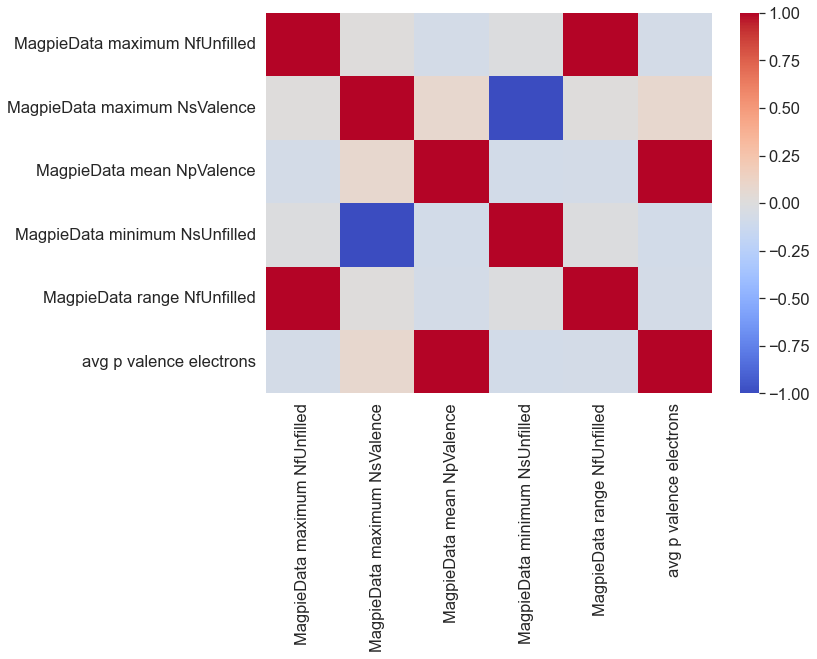

In [123]:
X_corr = X_df.corr()
corrplot(absHighPass(X_corr,0.8))

In [124]:
# There are some off-diagonals with a correlation of 1, so drop 1 of each of these pairs
X_df.drop(columns = ['MagpieData range NfUnfilled', 'MagpieData minimum NsUnfilled'], inplace = True)

## Skewness
Here, I check for skewness of the features and target. Some of the features are highly skewed due to low variance (i.e., most of the samples take on one value) - I chose to remove these from the data set. The target is also skewed and becomes more normal after log-transforming - I compare model training/prediction on both the gap and log-transformed gap in the ML section.

In [125]:
skew_val = X_df.skew(axis = 0)
skewed = skew_val[ abs( skew_val ) > 1.0 ]
skewed.sort_values()

MagpieData maximum NsValence          -46.411206
MagpieData mode NsValence              -4.482786
MagpieData maximum MendeleevNumber     -3.373687
MagpieData maximum SpaceGroupNumber    -2.877345
MagpieData maximum NdValence           -2.150029
MagpieData range NpValence             -1.531436
MagpieData mean Column                 -1.369912
MagpieData mode NpValence              -1.297114
compound possible                      -1.012035
MagpieData avg_dev MeltingT             1.236963
MagpieData mode NUnfilled               1.480174
MagpieData minimum NdValence            1.629140
MagpieData mean NUnfilled               1.787690
MagpieData minimum NpUnfilled           1.998195
MagpieData minimum MeltingT             2.108220
MagpieData mean MeltingT                2.109963
MagpieData mode GSbandgap               2.277050
MagpieData minimum NpValence            2.362313
MagpieData maximum NfUnfilled           2.594520
MagpieData mode NsUnfilled              6.955067
MagpieData mode NfVa

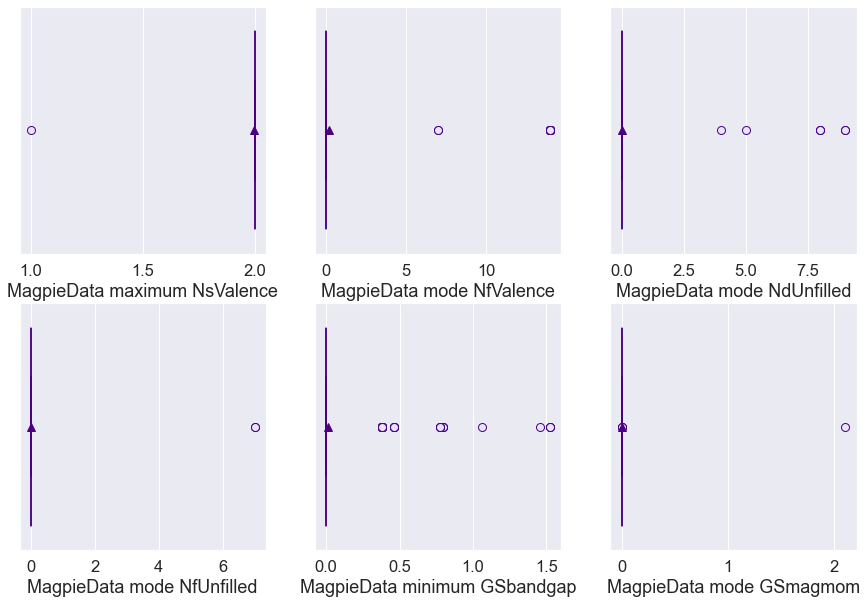

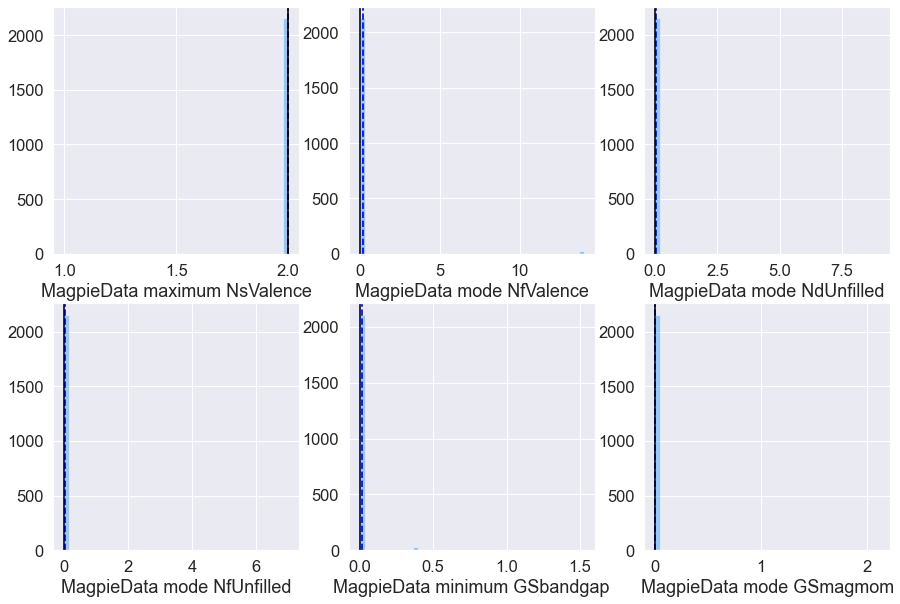

In [126]:
# Use threshold of 7.0 to identify highly skewed variables and plot their distributions
to_plot = skewed[ abs(skewed.sort_values()) > 7.0 ].index
boxplot(X_df, to_plot, nrows = 2)
distplot(X_df, to_plot, nrows = 2)

In [127]:
# Drop features with low variance
for feature in to_plot:
    this_var = df[feature].var()
    print('{}: {}'.format(feature, this_var))
    if this_var < 0.1:
        X_df.drop(columns = [feature], inplace = True)

MagpieData maximum NsValence: 0.0004642525533890072
MagpieData mode NfValence: 2.3816375932009497
MagpieData mode NdUnfilled: 0.1829040776166446
MagpieData mode NfUnfilled: 0.04547561843916777
MagpieData minimum GSbandgap: 0.009787885679803538
MagpieData mode GSmagmom: 0.0020681974869131985


### Log transformations
Does not help features, but helps target, so I only include the log-transformed target in the final dataframe.

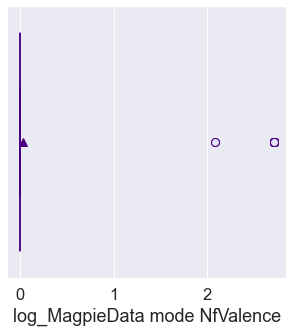

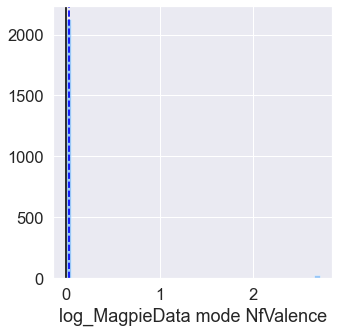

In [128]:
X_df['log_MagpieData mode NfValence'] = np.log(X_df['MagpieData mode NfValence']+1)
boxplot(X_df, ['log_MagpieData mode NfValence'], nrows = 1, figsize = (5,5))
distplot(X_df, ['log_MagpieData mode NfValence'], nrows = 1, figsize = (5,5))
X_df.drop(columns = ['MagpieData mode NfValence','log_MagpieData mode NfValence'],inplace = True)

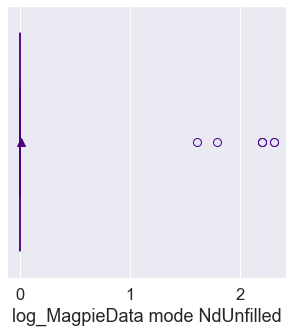

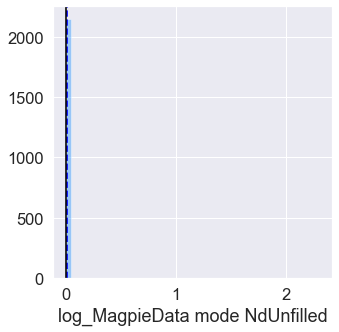

In [129]:
X_df['log_MagpieData mode NdUnfilled'] = np.log(X_df['MagpieData mode NdUnfilled']+1)
boxplot(X_df, ['log_MagpieData mode NdUnfilled'], nrows = 1, figsize = (5,5))
distplot(X_df, ['log_MagpieData mode NdUnfilled'], nrows = 1, figsize = (5,5))
X_df.drop(columns = ['MagpieData mode NdUnfilled','log_MagpieData mode NdUnfilled'],inplace = True)

In [130]:
# Check target
y.skew(axis = 0)

1.5909363551422124

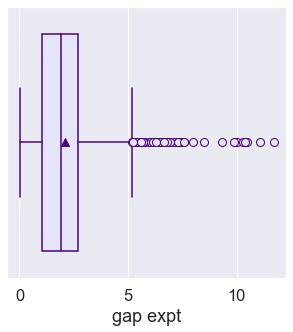

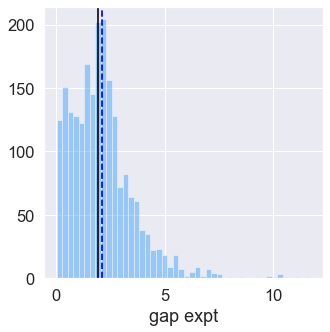

In [131]:
boxplot(df, ['gap expt'], nrows = 1, figsize = (5,5))
distplot(df, ['gap expt'], nrows = 1, figsize = (5,5))

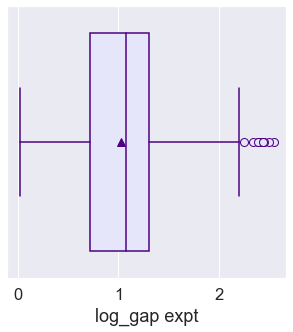

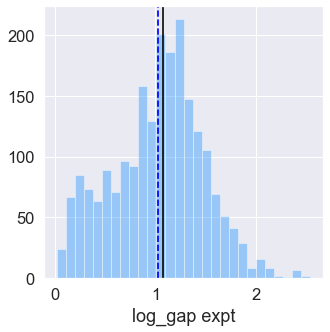

In [132]:
df['log_gap expt'] = np.log(y+1)
boxplot(df, ['log_gap expt'], nrows = 1, figsize = (5,5))
distplot(df, ['log_gap expt'], nrows = 1, figsize = (5,5))

## Principal component analysis
Here, I perform PCA to see if the data is clustered. As it is not, no further clustering analysis is performed.

In [133]:
# Scale data (necessary for PCA!)
scaler = StandardScaler()
X_scaled = pd.DataFrame( scaler.fit_transform(X_df), columns = X_df.columns )
# Start with 3 components
pca = PCA(n_components=3)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X_scaled)

[0.18465613 0.16207721 0.09739496]


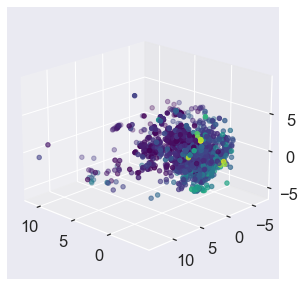

In [134]:
fig = plt.figure(1, figsize=(10, 5))
ax = fig.add_subplot(111, projection="3d", elev=20, azim=134)
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')

[0.18465613 0.16207721]


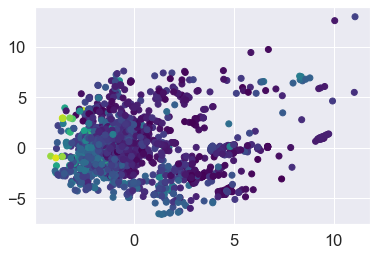

In [135]:
# Now check in two dimensions
pca = PCA(n_components=2)
pca.fit(X_scaled)
print(pca.explained_variance_ratio_)
X_pca = pca.transform(X_scaled)
fig,ax = plt.subplots()
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')

# Full model training & Prediction
Here, I perform model training and prediction on the entire data set and evaluate the performance of each model with 5-fold cross-validation. I test the effect of log-transforming the gap, as well as removing outliers in the gap.

In [136]:
# First tune without log transformation of target
params, model, top_feat = tune(X_scaled, y, outf = 'full_model')
cross_val_score(model, X_scaled[top_feat], y, scoring = 'neg_mean_absolute_error', cv = 5)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits


array([-0.62363674, -0.50495554, -0.46024986, -0.546614  , -0.53014839])

In [137]:
# Next tune with log transformation of target
params_log, model_log, top_feat_log = tune(X_scaled, np.log(y), outf = 'full_model_log')
cross_val_score(model, X_scaled[top_feat_log], np.log(y), scoring = 'neg_mean_absolute_error', cv = 5)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits


array([-0.45466638, -0.3258707 , -0.29189545, -0.31453482, -0.43603847])

In [138]:
# Next tune remove outliers in target
outliers_inds = np.abs(stats.zscore(y)) < 3
y_no_out = y[outliers_inds]
X_no_out = X_scaled.drop(outliers_inds[(outliers_inds == False)].index)
params_no_out, model_no_out, top_feat_no_out = tune(X_no_out, np.log(y_no_out), outf = 'full_model_log_noout')
cross_val_score(model, X_no_out[top_feat_no_out], np.log(y_no_out), scoring = 'neg_mean_absolute_error', cv = 5)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits


array([-0.46310947, -0.32240531, -0.29046138, -0.31425446, -0.44007917])

In [139]:
# Predict with no log and with outliers
X_train, X_test, y_train, y_test = train_test_split(X_df[top_feat], y, random_state = 0)
model.fit(X_train,y_train)
y_pred = model.predict(X_test)

In [140]:
# Predict with log and with outliers
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X_df[top_feat_log], np.log(y), random_state = 0)
model_log.fit(X_train_log,y_train_log)
y_pred_log = model_log.predict(X_test_log)

In [141]:
# Predict with log and no outliers
X_train_no_out, X_test_no_out, y_train_no_out, y_test_no_out = train_test_split(X_no_out[top_feat_no_out], 
                                                                                np.log(y_no_out), random_state = 0)
model_no_out.fit(X_train_no_out,y_train_no_out)
y_pred_no_out = model_no_out.predict(X_test_no_out)

0.7203245960771691


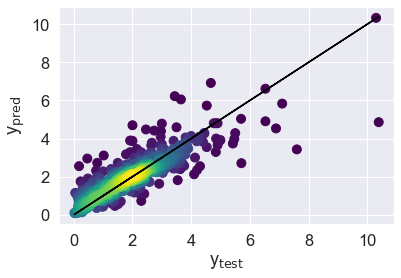

In [142]:
predvtrue(y_test.to_numpy(), y_pred)
print(r2_score(y_test, y_pred))

0.7227182343141836


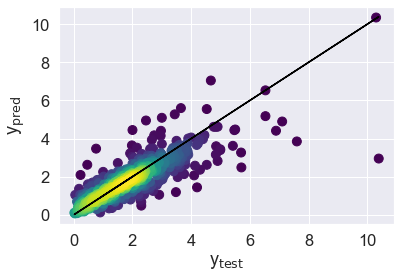

In [143]:
predvtrue(np.exp(y_test_log.to_numpy()), np.exp(y_pred_log))
print(r2_score(y_test_log, y_pred_log))

0.7251008365645444


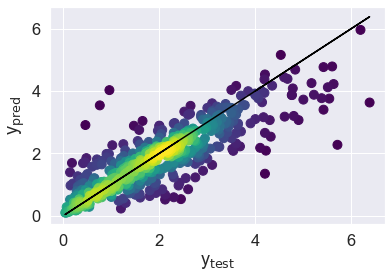

In [144]:
predvtrue(np.exp(y_test_no_out.to_numpy()), np.exp(y_pred_no_out))
print(r2_score(y_test_no_out, y_pred_no_out))

### Observations
All models have similar $R^2$ but vary slightly in $MAE$. Further improvements could be made with more extensive feature engineering, hyperparameter tuning, and aggregation of predictions from different models.

# Active learning

The goal of this section is to guide the exploration of design space to identify compositions with a high band gap. In a real life scenario, we could use active learning to choose which experiments or simulations to prioritize. 

We start initially with 10 data points, then incrementally add 5 at each active learning step.

In [145]:
# Select initial training set
np.random.seed(100)

in_train = np.zeros(len(X_scaled), dtype=bool)
in_train[np.random.choice(len(X_scaled), 10, replace=False)] = True
assert not np.isclose(max(y), max(y[in_train]))

In [146]:
# Initial hyperparameter tuning and feature selection. Here, I only do this once, but ideally would do at 
# every step or every number of steps. Performing feature selection is important here for avoiding the curse
# of dimensionality (having many more features than samples).
all_inds = set(range(len(y)))
train = [np.where(in_train)[0].tolist()]
train_inds = train[-1].copy()    # Initial Set
search_inds = list(all_inds.difference(train_inds)) # All samples not in the current set
# Hyperparameter tuning and feature selection
params, model, top_feat = tune(X_scaled, y, np.array(train_inds), outf = 'active_model')
X_top = np.array(X_scaled[top_feat])
# Model training and prediction with tuned hyperparameters and features
model = RandomForestRegressor(num_trees = params['n_estimators'], max_depth = params['max_depth'])
model.fit(X_top[train_inds], y[train_inds])

Fitting 3 folds for each of 30 candidates, totalling 90 fits
Fitting 3 folds for each of 30 candidates, totalling 90 fits


RandomForestRegressor(max_depth=100, num_trees=100)

In [147]:
%%capture
# Active learning steps
n_steps = 50
mae = np.zeros((4,n_steps))
y_max = np.zeros((4,n_steps))
for a,acq in enumerate(['random', 'mei', 'mli', 'mu']):
    train = [np.where(in_train)[0].tolist()]
    for i in range(n_steps):
        train_inds = train[-1].copy()    # Initial Set
        search_inds = list(all_inds.difference(train_inds)) # All samples not in the current set
        model.fit(X_top[train_inds], y[train_inds])
        y_pred, y_std = model.predict(X_top[search_inds], return_std = True) # Predictions
        mae[a,i] = mean_absolute_error(y[search_inds], y_pred)
        y_max[a,i] = max( y[train_inds] )
        # Update training set
        train_inds = update(X_scaled, y_pred, y_std, train_inds, acq=acq)
        train.append(train_inds) # Storage of the current set per step

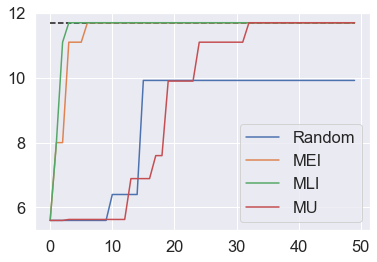

In [148]:
# Compare ability of each acquisition function to find materials with high gaps
true_max = max(y)
random_max = y_max[0,:]
mei_max = y_max[1,:]
mli_max = y_max[2,:]
mu_max = y_max[3,:]
fig,ax = plt.subplots()
ax.plot(range(n_steps), [true_max]*n_steps, 'k', linestyle = 'dashed')
ax.plot(range(n_steps), random_max, label='Random')
ax.plot(range(n_steps), mei_max, label='MEI')
ax.plot(range(n_steps), mli_max, label='MLI')
ax.plot(range(n_steps), mu_max, label='MU')
ax.legend()

### Observations
All acquisition functions to better than selecting at random and find the material with the maximum gap within 20 steps.

# Conclusions
Conventional machine learning training was used to develop a model that can predict the experimental band gap purely from composition with an $R^2$ of approximately 0.7 and an $MAE$ of approximately 0.15 eV. Active learning was successful in accelerating the exploration of design space to maximize the band gap. Further development could include further feature engineering and testing of different algorithms.